# Graph Theory

In [284]:
## import required packages for Assignment
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf
import random
from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic

In [110]:
## retrieve datasets
datadir = "../Datasets/"

### Question 2) 

In [111]:
## load nlinks csv file
df = pd.read_csv(datadir + "GridNorthAmerica/gridkit_north_america-highvoltage-links.csv")
## retrieve edge list by extracting info from the columns with edges
edges = df[['v_id_1', 'v_id_2']]
## reformat data frame in readable format for Read_Ncol (.txt file with no headers and no index)
edges.to_csv("edges.txt", sep = " ", index = False, header = False)

## create undirected, simple graph using edge list for the network
NorthAmericaGrid = ig.Graph.Read_Ncol("edges.txt", directed = False)
NorthAmericaGrid = NorthAmericaGrid.simplify()

In [330]:
## read nodes and their attributes
Attr = pd.read_csv(datadir + "GridNorthAmerica/gridkit_north_america-highvoltage-vertices.csv")
## Attr.head()
## retrieve list of attributes that are desired
attributes = Attr[['v_id', 'lon', 'lat', 'typ']]
## attributes.head()

In [117]:
## build attribute dictionaries of each node
Longitude = dict(zip(attributes.v_id, attributes.lon))
Latitude = dict(zip(attributes.v_id, attributes.lat))
Type = dict(zip(attributes.v_id, attributes.typ))
## Voltage = dict(zip(Attr.v_id, Attr.voltage))
## Frequency = dict(zip(Attr.v_id, Attr.frequency))
## Name = dict(zip(Attr.v_id, Attr.name))
## Operator = dict(zip(Attr.v_id, Attr.operator))
## Ref = dict(zip(Attr.v_id, Attr.ref))
## Wkrt = dict(zip(Attr.v_id, Attr.wkt_srid_4326))

In [118]:
## map names to integers for easier referencing
NorthAmericaGrid.vs["id"] = [int(x) for x in NorthAmericaGrid.vs["name"]]

## save longitude, latitude and node type in the graph
NorthAmericaGrid.vs["longitude"] = [Longitude[i] for i in NorthAmericaGrid.vs["id"]]
NorthAmericaGrid.vs["latitude"] = [Latitude[i] for i in NorthAmericaGrid.vs["id"]]
NorthAmericaGrid.vs["type"] = [Type[i] for i in NorthAmericaGrid.vs["id"]]

In [119]:
## compute and store basic statistics in a dataframe
def baseStats(G):
    deg = G.degree()
    return [
        G.vcount(),
        G.ecount(),
        np.min(deg),
        np.mean(deg),
        np.median(deg),
        np.quantile(deg, 0.99),
        np.max(deg),
        G.diameter(),
        np.max(G.connected_components().membership) + 1,
        G.connected_components().giant().vcount(),
        sum([x == 0 for x in deg]),
        G.transitivity_undirected(mode = "nan"),
        G.transitivity_avglocal_undirected(mode = "nan"),
    ]

In [121]:
%%time
## compute stats for the North America graph
S = []
S.append(["North America"] + baseStats(NorthAmericaGrid))

CPU times: user 14.7 s, sys: 312 ms, total: 15 s
Wall time: 17.9 s


In [122]:
## store in a dataframe and display results
df = pd.DataFrame(
    S,
    columns = [
        "network",
        "# nodes",
        "# edges",
        r"$\delta$",
        r"$\langle k\rangle$",
        r"median degree",
        r"$d_{quant_{99}}$",
        r"$\Delta$",
        "diameter",
        "# components",
        "the largest component",
        "# isolates",
        r"$C_{glob}$",
        r"$C_{loc}$",
    ],
).transpose()
df

,0
network,North America
# nodes,16167
# edges,20242
$\delta$,1
$\langle k\rangle$,2.504113
median degree,2.0
$d_{quant_{99}}$,7.0
$\Delta$,22
diameter,138
# components,34


### Question 1 Analysis

Based on the results from the output of the code in Question 1, the North America Grid network has 16,167 nodes and 20,242 edges. The smallest degree is 1, with median degree of 2, average degree of 2.5, and largest degree of 22. The median degree is smaller than the average degree, and the overall degree distribution can be said to be uniform and has regular patterns. The diameter is 138, which can mean that the nodes are not as tightly connected to each other. The number of connected components is 34. The largest component is 14,990 which means that the giant component has 14,990 nodes. There are no nodes with degree 0 meaning that all nodes are connected. The global and local clustering coefficients are very close in value, which can indicate that every node in the network has a very similar level of clustering to the overall network average, similar to d-regular graphs. 

In comparison to the Europe Grid network, the North America network has more nodes and edges, with similar smallest, average, median, and max degrees. The diameter is smaller for the North America Grid than the Europe grid, meaning that the nodes are more tightly connected for the North America network. The Europe Grid network has a larger numbrer of connected components, but has a smaller giant component. Both networks have no nodes with degree 0. The North America network has a slightly large global clustering coefficient, and the Europe grid has a alrger local clustering coefficient.

### Question 4)

#### 4a)

In [338]:
## read edge list with weights for Airport dataset, ignore first row (column names)
connections_df = pd.read_csv(datadir + "Airports/connections.csv", skiprows = 1, names = ["origin", "destination", "passengers"])
## save weights of edges in list by retrieving passenger column info 
weights = connections_df["passengers"].tolist()
## save edges in separate data frame
edges = connections_df[['origin', 'destination']]
## reformat data frame in readable format for Read_Ncol (.txt file with no headers and no index)
edges.to_csv("edges.txt", sep = " ", index = False, header = False)
## create undirected, simple graph using edge list for the network
Airport = ig.Graph.Read_Ncol("edges.txt", directed=True)
## assign weights to the edges
Airport.es['weight'] = weights

In [339]:
## read nodes and their attributes
Attr = pd.read_csv(datadir + "Airports/airports_loc.csv")
## Attr.head()

In [340]:
## build attribute dictionaries for each node
Longitude = dict(zip(Attr.airport, Attr.lon))
Latitude = dict(zip(Attr.airport, Attr.lat))
State = dict(zip(Attr.airport, Attr.state))
City = dict(zip(Attr.airport, Attr.city))

In [341]:
## Airport.vs[0]

In [342]:
Airport.vs["longitude"] = [Longitude[i] for i in Airport.vs["name"]]
Airport.vs["latitude"] = [Latitude[i] for i in Airport.vs["name"]]
Airport.vs["state"] = [State[i] for i in Airport.vs["name"]]
Airport.vs["city"] = [City[i] for i in Airport.vs["name"]]

Slope of Line: 0.2956875492282546


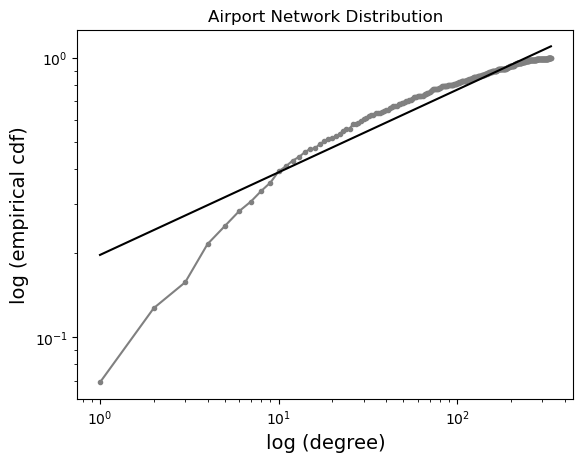

In [343]:
## degree distribution for Airport graph
deg = Airport.degree()
e = ecdf(deg) ## empirical cdf
x = np.arange(1, max(deg), 1)
y = [e(i) for i in x]

## fit a regression on log-log scale
X = [np.log(i) for i in x]
Y = [np.log(i) for i in y] 
regressor = LinearRegression()
regressor.fit(np.array(X).reshape(-1, 1), Y)

## extract regression coefficients (slope, intercept)
a = regressor.coef_[0]
b = regressor.intercept_

## plot on log-log scale
plt.loglog(x, y, ".-", color = "grey")
plt.xlabel("log (degree)", fontsize = 14)
plt.ylabel("log (empirical cdf)", fontsize = 14)
plt.title("Airport Network Distribution");
min_deg = min(x)
max_deg = max(x)
plt.plot([min_deg, max_deg], [np.exp(b) * min_deg**a, np.exp(b) * max_deg**a], color = "black")

## print slope
print("Slope of Line:", a)

#### 4b)

In [344]:
## calculate in-degrees and out-degrees
in_degrees = Airport.indegree()  
out_degrees = Airport.outdegree()

## calculate total degree (in-degree + out-degree)
total_degrees = [in_degrees[i] + out_degrees[i] for i in range(len(Airport.vs))]

## retrieve index of airport with the max total degree
max_degree_index = total_degrees.index(max(total_degrees))
## retrieve name of airport with max total degree
airport_with_max_degree = Airport.vs[max_degree_index]['name']

## print results
print(f"The airport with the highest degree is {airport_with_max_degree} with a degree of {total_degrees[max_degree_index]}")

The airport with the highest degree is ATL with a degree of 336


#### 4c)

In [345]:
## retrieve strong connected components in graph
scc = Airport.components(mode = "strong")
## count total # of strong connected components
count_scc = len(scc)
## print results
print(f"The number of strongly connected components is: {count_scc}")

The number of strongly connected components is: 40


#### 4d)

In [347]:
## extract California airports data
california_airports = Attr[Attr["state"] == "CA"]["airport"].tolist()
## induce subgraph
california_subgraph = Airport.subgraph(california_airports)
## find isolated nodes
isolated_nodes = [v.index for v in california_subgraph.vs if california_subgraph.degree(v) == 0]
## retrieve number of isolated nodes
num_isolated = len(isolated_nodes)
print(f"Number of isolated nodes in the subgraph of airports from California: {num_isolated}")

Number of isolated nodes in the subgraph of airports from California: 9


### Question 4 Analysis

The cumulative distribution plot for the Airport network does not extend to very large values for the degrees. The slope of the line found using linear regression is approximately 0.30. The busiest airport with the maximum total degree was found to be ATL with a degree of 336. The number of strongly connected components in the network is 40. The number of isolated nodes in the subgraph of airports from California is 9.

### Question 5)

In [309]:
## read edge list for the grid network and build undirected simple graph
EuropeGrid = ig.Graph.Read_Ncol(datadir + "GridEurope/gridkit_europe-highvoltage.edges", directed=False)
EuropeGrid = EuropeGrid.simplify()

In [332]:
## read the nodes and their attributes
Attr = pd.read_csv(datadir + "GridEurope/gridkit_europe-highvoltage.vertices")
## Attr.head()

In [311]:
## build attribute dictionaries
Longitude = dict(zip(Attr.v_id, Attr.lon))
Latitude = dict(zip(Attr.v_id, Attr.lat))
Type = dict(zip(Attr.v_id, Attr.typ))

In [312]:
## map names to integers for easier referencing
EuropeGrid.vs["id"] = [int(x) for x in EuropeGrid.vs["name"]]

## save longitude, latitude and node type in the graph
EuropeGrid.vs["longitude"] = [Longitude[i] for i in EuropeGrid.vs["id"]]
EuropeGrid.vs["latitude"] = [Latitude[i] for i in EuropeGrid.vs["id"]]
EuropeGrid.vs["type"] = [Type[i] for i in EuropeGrid.vs["id"]]

In [326]:
## create list of nodes and 100 random pairs 
nodes = list(EuropeGrid.vs)
random_pairs = [(random.choice(nodes), random.choice(nodes)) for _ in range(100)]

In [327]:
## for storing distances
graph_distances = []
geo_distances = []

for _ in range(100):
    ## sample 2 random nodes from set of 100 verticies
    node1, node2 = random.sample(V.tolist(), 2) 
    
    ## get graph distance of nodes using shortest paths
    graph_dist = EuropeGrid.distances(source = node1, target = node2)[0][0]
    graph_distances.append(graph_dist)
    
    ## get longitude and latitude of each pair nodes
    lat1, lon1 = EuropeGrid.vs[node1]["latitude"], EuropeGrid.vs[node1]["longitude"]
    lat2, lon2 = EuropeGrid.vs[node2]["latitude"], EuropeGrid.vs[node2]["longitude"]
    
    ## calculate geographical distance in kilometers using geodesic
    geo_dist = geodesic((lat1, lon1), (lat2, lon2)).km 
    geo_distances.append(geo_dist)

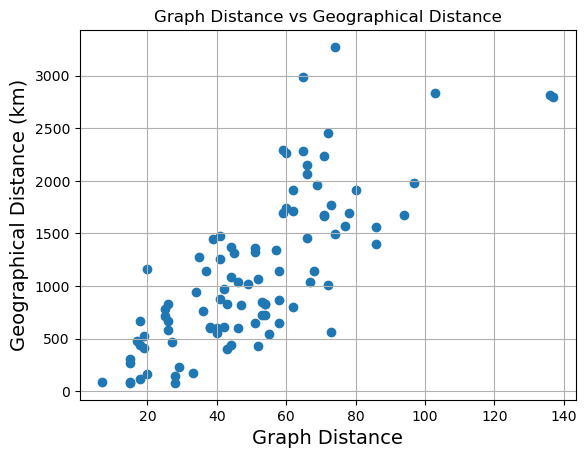

In [333]:
plt.scatter(graph_distances, geo_distances)
plt.xlabel('Graph Distance', fontsize = 14)
plt.ylabel('Geographical Distance (km)', fontsize = 14)
plt.title('Graph Distance vs Geographical Distance')
plt.grid(True)
plt.show()

In [351]:
correlation = pd.DataFrame({"graph_distance": graph_distances, "geo_distance": geo_distances}).corr()
print(correlation)

                graph_distance  geo_distance
graph_distance        1.000000      0.766578
geo_distance          0.766578      1.000000


### Question 5 Analysis

Based on the graph generated by the code, it can be said that there is there is a positive correlation between the graph distance and the geographical distance. The graph is trending upwards, showing a increase, positive relation. This indicates that as the graph distance increases, the geographical distance increases as well. From the correlation matrix calculation it is evident that the two variables have a postive correlation (0.766578).

### Question 7)

In [329]:
## read the GitHub edge list as tuples and build undirected graph
df = pd.read_csv(datadir + "GitHubDevelopers/musae_git_edges.csv") # read data in data frame using pandas
GitHubGraph = ig.Graph.TupleList(
    [tuple(x) for x in df.values], directed=False, vertex_name_attr="id"
)

In [348]:
## read node attributes
Attr = pd.read_csv(datadir + "GitHubDevelopers/musae_git_target.csv")
## Attr.head()

In [215]:
## build attribute dictionaries
Names = dict(zip(Attr.id, Attr.name))
ML = dict(zip(Attr.id, Attr.ml_target))

In [216]:
## add name attributes to graph
GitHubGraph.vs["name"] = [Names[i] for i in GitHubGraph.vs["id"]]

## add a class: 'ml' or 'web' depending on attribute 'ml_label'
labels = ["web", "ml"]
GitHubGraph.vs["class"] = [labels[ML[i]] for i in GitHubGraph.vs["id"]]

In [217]:
## build subgraphs
subgraph_ml = GitHubGraph.subgraph([v for v in GitHubGraph.vs() if v["class"] == "ml"])
subgraph_web = GitHubGraph.subgraph([v for v in GitHubGraph.vs() if v["class"] == "web"])

In [225]:
## compute and store basic statistics in a dataframe
def baseStats(G):
    deg = G.degree()
    return [ 
        G.transitivity_avglocal_undirected(mode="nan"), # Method 1 - Excludes nodes with degree 0 or 1
        G.transitivity_avglocal_undirected(mode="zero") # Method 2 - Assigns 0 to nodes with degree 0 or 1
    ]

In [226]:
%%time
## compute local clustering coefficients for the 4 graphs
S = []
S.append(["GitHub"] + baseStats(GitHubGraph))
S.append(["GitHub (ml)"] + baseStats(subgraph_ml))
S.append(["GitHub (web)"] + baseStats(subgraph_web))
S.append(["Grid"] + baseStats(Grid))

CPU times: user 228 ms, sys: 26.2 ms, total: 254 ms
Wall time: 262 ms


In [227]:
## store in a dataframe
df = pd.DataFrame(
    S,
    columns=[
        "network",
        r"$C_{loc1}$",
        r"$C_{loc2}$",
    ],
).transpose()
df

,0,1,2,3
network,GitHub,GitHub (ml),GitHub (web),Grid
$C_{loc1}$,0.193421,0.141246,0.207105,0.112638
$C_{loc2}$,0.167537,0.071921,0.179174,0.089499


### Question 7 Analysis

Based on the results shown in the table, the local clustering coefficients differ based on the method used for calculation. The first method ignores nodes of degree 0 or 1; the second method assigns c(v) = 0 to these nodes. It is shown that the second method results in smaller clustering coefficients. This makes sense because method 2 includes more nodes (many of which have c(v) = 0 or 1), and as a result the clustering coefficient will always be smaller than the one obtained using method 1 because those nodes would bring the overall average down.